Again all credit to https://github.com/nikhilbarhate99/PPO-PyTorch

Before I copy and paste in that code for the continuous PPO however, I want to try and guess what I have to do. 

In the act action in the actor critic class, it should be a normal distribution, not a continuous. Additionally, the output of the actor should be a mean and standard deviation, so two values? 

No. It's as many values as are in the distribution, so a multivariate gaussian corresponding to 2x the number of actions.

One of these actions is the mean, and can be any value. The standard deviation has to be greater than 0, so whatever the network outputs, take the exponential of it.


It appears there are some differences between my guess and the output, mainly that the std is a pre-defined value, and that the mean is bounded between -1 and 1. Let's see how this works!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
import gym
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Memory:
    """
    For the old policy, collect a tuple of (states,actions,logprobs,rewards,done)
    which gives information on how this old policy performs, and can be immediately compared to the candidate one. 
    """
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std):
        super(ActorCritic, self).__init__()
        # action mean range -1 to 1
        self.actor =  nn.Sequential(
                nn.Linear(state_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, action_dim),
                nn.Tanh() 
                )
        # critic
        self.critic = nn.Sequential(
                nn.Linear(state_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
                )
        self.action_var = torch.full((action_dim,), action_std*action_std).to(device) #actor takes actions according to a multi-variate gaussian. Network finds the means, 
        #standard deviations are given like this. 
        
    def forward(self):
        raise NotImplementedError
    
    def act(self, state, memory):
        action_mean = self.actor(state)
        cov_mat = torch.diag(self.action_var).to(device) #covariance of all 1's. 
        
        dist = MultivariateNormal(action_mean, cov_mat)
        # this fixes lunar lander issue I believe. 
        action = dist.sample() #sample actions from multivariate. 
      #  action = np.tanh(action)
        action_logprob = dist.log_prob(action) #convert to log probability scores of these actions (log pi) vector
        
        #save these things to the memory. This is for all the OLD actions and logprobs, and are immedaitely compared to how the candidate policy performs on the 
        # memory saved state
        memory.states.append(state) 
        memory.actions.append(action)
        memory.logprobs.append(action_logprob)
        
        return action.detach()
    
    def evaluate(self, state, action):   
        #Compare the new policies predictions
        # Inputs a state and action, outputsa log probability and entropy. 
        action_mean = self.actor(state)
        
        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy

In [ ]:
class PPO:
    def __init__(self, state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip):
        # Hyper parameters
        
        
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        
        self.policy_old = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def select_action(self, state, memory):
        # select an acion from the old policy + memory . 
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.policy_old.act(state, memory).cpu().data.numpy().flatten()
    
    def update(self, memory):
        # Monte Carlo estimate of rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards:
        rewards = torch.tensor(rewards).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert lists to tensors
        old_states = torch.squeeze(torch.stack(memory.states).to(device), 1).detach()
        old_actions = torch.squeeze(torch.stack(memory.actions).to(device), 1).detach()
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs), 1).to(device).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # The new state values and log probabilities under the candidate policy change.  :
            # The old actions are also inputted because that provides the dist entropy bonus aka encourage exploration. 
            
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()    # advantage value 
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy:
        
        
        self.policy_old.load_state_dict(self.policy.state_dict())
  

In [ ]:

############## Hyperparameters ##############
env_name = "BipedalWalker-v2"
#env_name = "LunarLanderContinuous-v2"
render = False
solved_reward = 300         # stop training if avg_reward > solved_reward
log_interval = 20           # print avg reward in the interval
max_episodes = 10000        # max training episodes
max_timesteps = 1500        # max timesteps in one episode

update_timestep = 4000      # update policy every n timesteps
action_std = 0.5            # constant std for action distribution (Multivariate Normal)
K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr = 0.0003                 # parameters for Adam optimizer
betas = (0.9, 0.999)  # these are used for computing running averages in adam, and are the same as torch's default. 

random_seed = None
#############################################

# creating environment
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

if random_seed:
    print("Random Seed: {}".format(random_seed))
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)

memory = Memory()
ppo = PPO(state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip)
print(lr,betas)

# logging variables
running_reward = 0
avg_length = 0
time_step = 0
total_rewards = [] #list for plotting episode vs reward
# training loop
for i_episode in range(1, max_episodes+1):
    state = env.reset()
    for t in range(max_timesteps):
        time_step +=1
        # Running policy_old:
        action = ppo.select_action(state, memory)     # choose an action according to the old policy, save this action, log prob, etc. to memory. 
        state, reward, done, _ = env.step(action)

        # Saving reward and is_terminals:
        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        # update if its time
        if time_step % update_timestep == 0:
            ppo.update(memory)
            memory.clear_memory()
            time_step = 0
        running_reward += reward
        if render:
            env.render()
        if done:
            break
    total_rewards.append(running_reward)
    avg_length += t

    # stop training if avg_reward > solved_reward
    if running_reward > (log_interval*solved_reward):
        print("########## Solved! ##########")
        torch.save(ppo.policy.state_dict(), './PPO_continuous_solved_{}.pth'.format(env_name))
        break

    # save every 500 episodes
    if i_episode % 500 == 0:
        torch.save(ppo.policy.state_dict(), './PPO_continuous_{}.pth'.format(env_name))

    # logging
    if i_episode % log_interval == 0:
        avg_length = int(avg_length/log_interval)
        running_reward = int((running_reward/log_interval))

        print('Episode {} \t Avg length: {} \t Avg reward: {}'.format(i_episode, avg_length, running_reward))
        running_reward = 0
        avg_length = 0




#### %debug

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Total Reward')

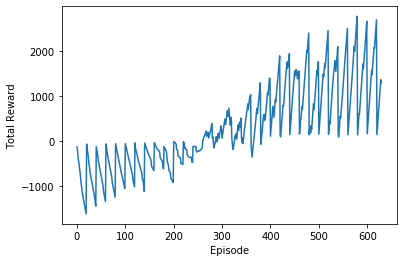

In [5]:
plt.plot(total_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")

Is there anything interesting about this?

# Adaptation of the test loop for once a model is already trained and ready for testing

In [ ]:
import gym
from PIL import Image
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def test():
    ############## Hyperparameters ##############
    env_name = "LunarLanderContinuous-v2"
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    n_episodes = 3          # num of episodes to run
    max_timesteps = 1500    # max timesteps in one episode
    render = True           # render the environment
    save_gif = False        # png images are saved in gif folder
    
    # filename and directory to load model from
    filename = "PPO_continuous_" +env_name+ ".pth"
    directory = ""

    action_std = 0.5        # constant std for action distribution (Multivariate Normal)
    K_epochs = 80           # update policy for K epochs
    eps_clip = 0.2          # clip parameter for PPO
    gamma = 0.99            # discount factor
    
    lr = 0.0003             # parameters for Adam optimizer
    betas = (0.9, 0.999)
    #############################################
    
    memory = Memory()
    ppo = PPO(state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip)
    #load in best model 
    ppo.policy_old.load_state_dict(torch.load(directory+filename))
    
    for ep in range(1, n_episodes+1):
        ep_reward = 0
        state = env.reset()
        for t in range(max_timesteps):
            action = ppo.select_action(state, memory)
            state, reward, done, _ = env.step(action)
            ep_reward += reward
            if render:
                env.render()
            if save_gif:
                 img = env.render(mode = 'rgb_array')
                 img = Image.fromarray(img)
                 img.save('./gif/{}.jpg'.format(t))  
            if done:
                break
            
        print('Episode: {}\tReward: {}'.format(ep, int(ep_reward)))
        ep_reward = 0
        env.close()
    
if __name__ == '__main__':
    test()
    
    